Dataset Path: ../data/processed/CIC_IOT_CSV_Dataset.csv
Dataset Shape: (6177739, 40)
Columns: ['Header_Length', 'Protocol Type', 'Time_To_Live', 'Rate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Variance', 'label']

First Few Rows:
    Header_Length  Protocol Type  Time_To_Live          Rate  fin_flag_number  \
0           19.8              6         63.36  42353.872564              0.0   
1            0.0             47         63.36   2270.345290              0.0   
2           10.4             17         44.80    127.490706              0.0   
3           25.6              6        148.50    235.799321              0.0   
4           20.0              6         

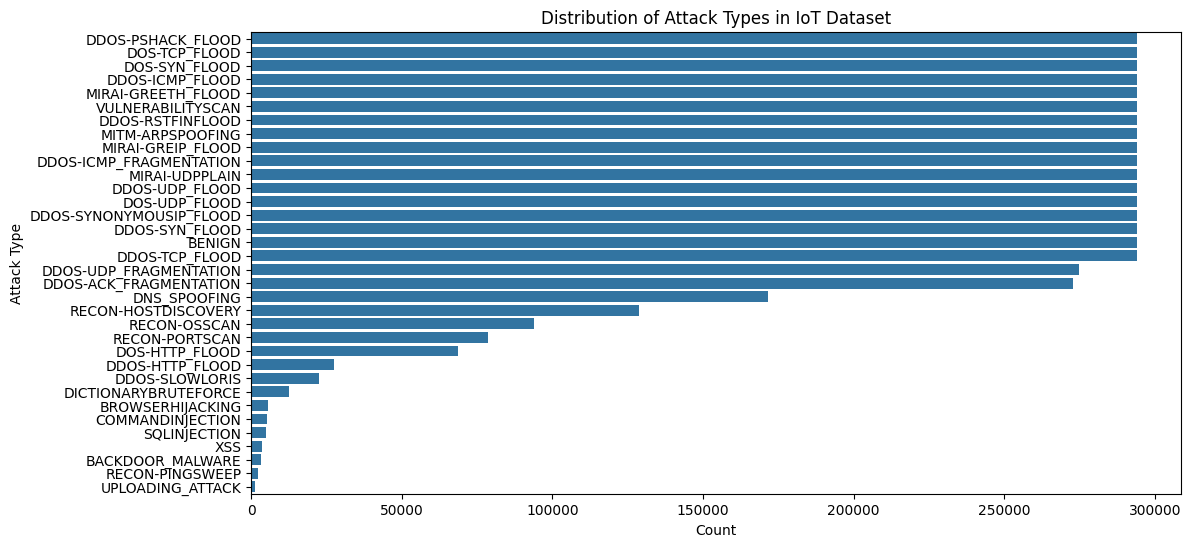

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define file path
csv_path = "../data/processed/CIC_IOT_CSV_Dataset.csv"

# Load the dataset
df = pd.read_csv(csv_path)

# Display basic dataset info
print("Dataset Path:", csv_path)
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nFirst Few Rows:\n", df.head())

# Check for missing values
print("\nMissing Values Count:\n", df.isnull().sum().sum())

# Display basic statistics
print("\nFeature Statistics:\n", df.describe())

# Identify categorical vs numerical columns
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
print("\nCategorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

# Visualize attack distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=df['label'], order=df['label'].value_counts().index)
plt.title("Distribution of Attack Types in IoT Dataset")
plt.xlabel("Count")
plt.ylabel("Attack Type")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


# Feature Importance Study

In [6]:
import pandas as pd

# Import Processed Data
processed_data_path = "../data/processed/CIC_IOT_CSV_Dataset.csv"
df = pd.read_csv(processed_data_path)

# Create a multiclass label: DDOS, MIRAI, or BENIGN
def categorize_label(label):
    label = str(label).upper().strip()
    if label.startswith("DDOS"):
        return "DDOS"
    elif label.startswith("MIRAI"):
        return "MIRAI"
    elif label == "BENIGN":
        return "BENIGN"
    else:
        return "OTHER"

df['simple_label'] = df['label'].apply(categorize_label)
# Keep only the desired classes
df = df[df['simple_label'].isin(["DDOS", "MIRAI", "BENIGN"])].copy()

# Define features and multiclass target
features = df.drop(columns=['label', 'simple_label'])
target = df['simple_label']


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [8]:
from sklearn.metrics import classification_report, accuracy_score
y_pred = clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     58807
        DDOS       1.00      1.00      1.00    590300
       MIRAI       1.00      1.00      1.00    176302

    accuracy                           1.00    825409
   macro avg       1.00      1.00      1.00    825409
weighted avg       1.00      1.00      1.00    825409

Accuracy Score: 0.9993893936218287


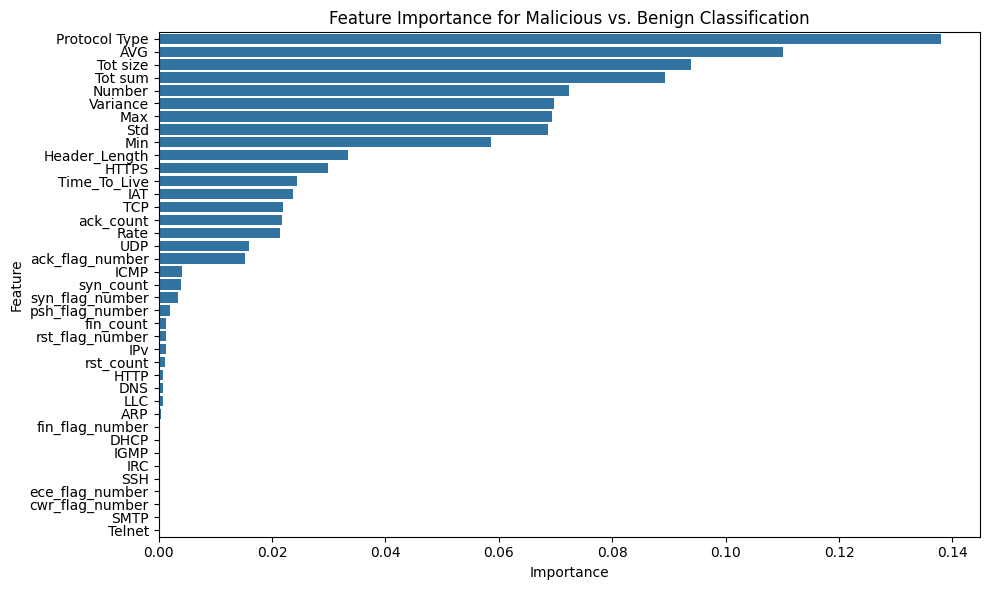

In [ ]:
# Extract feature importances
importances = clf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({"feature": feature_names, "importance": importances})
importance_df.sort_values(by="importance", ascending=False, inplace=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=importance_df)
plt.title("Feature Importance for Malicious vs. Benign Classification")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

/var/folders/09/s5nx4gn95nj0kqjmzvm1jcy00000gn/T/ipykernel_70267/1742282101.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_plot.groupby('simple_label', group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size)))


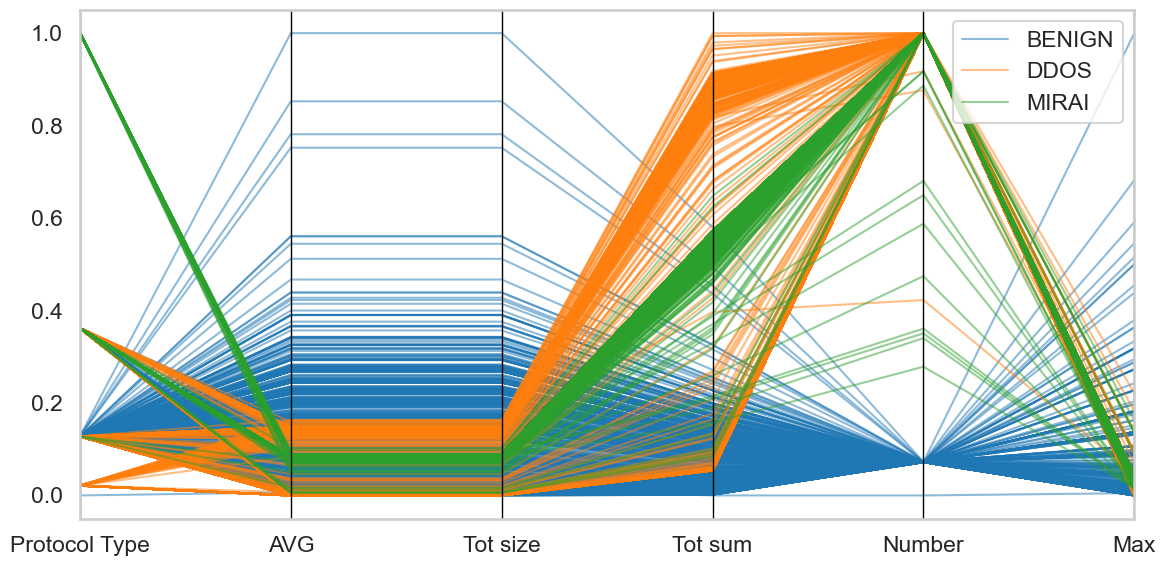

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk") 

# Function to simplify labels
def categorize_label(label):
    label = str(label).upper().strip()
    if label.startswith("DDOS"):
        return "DDOS"
    elif label.startswith("MIRAI"):
        return "MIRAI"
    elif label == "BENIGN":
        return "BENIGN"
    else:
        return "OTHER"

df['simple_label'] = df['label'].apply(categorize_label)
df_plot = df[df['simple_label'].isin(["DDOS", "MIRAI", "BENIGN"])].copy()

# Define the top X features for the plot
top_features = ['Protocol Type', 'AVG', 'Tot size', 'Tot sum', 'Number', 'Max']

# Sample a fixed number of rows per group (e.g., 10,000 per label)
sample_size = 1000
sampled_df = df_plot.groupby('simple_label', group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size)))

# Create a new DataFrame with only the selected features and the attack type
plot_df = sampled_df[top_features + ['simple_label']].copy()

# Scale the features for visualization
scaler = MinMaxScaler()
plot_df[top_features] = scaler.fit_transform(plot_df[top_features])

# Create the parallel coordinate plot

plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
parallel_coordinates(
    plot_df, 
    'simple_label', 
    color=colors,
    alpha=0.5,
    linewidth=1.5,
)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: 'DDOS-PSHACK_FLOOD'

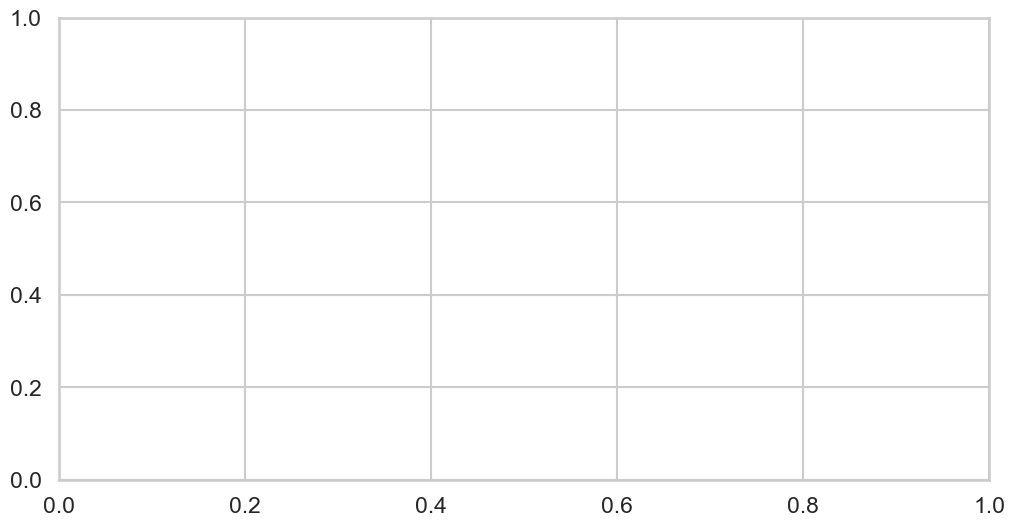

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
sns.set_context("talk")

# Define the top features
top_features = ['Protocol Type', 'AVG', 'Tot size', 'Tot sum', 'Number', 'Max']

# Step 1: Filter or cap outliers
def remove_outliers(df, features, upper_percentile=99):
    for col in features:
        # Calculate the percentile threshold
        cutoff = np.percentile(df[col], upper_percentile)
        # Drop rows exceeding that threshold
        df = df[df[col] <= cutoff]
    return df

# Make a copy so we don't alter the original
filtered_df = df_plot.copy()
filtered_df = remove_outliers(filtered_df, top_features, upper_percentile=99)

# Step 2: Scale after outlier removal
scaler = MinMaxScaler()
filtered_df[top_features] = scaler.fit_transform(filtered_df[top_features])

# Step 3: Plot parallel coordinates
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
parallel_coordinates(
    filtered_df, 
    'simple_label',
    color=colors,
    alpha=0.5,
    linewidth=1.5,
)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
